In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=False)

#put the path to the directory with .csv files and 'images' folder on your google drive
datapath = '/content/drive/My Drive/ai-side-projects/3dshapes_autoencoder'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Loading data: [Shapes 3D](https://github.com/google-deepmind/3d-shapes/tree/master)

 following [their notebook](https://github.com/google-deepmind/3d-shapes/blob/master/3dshapes_loading_example.ipynb)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import tensorflow as tf


In [ ]:
# load dataset
dataset = h5py.File(datapath+'/3dshapes.h5', 'r')
print(dataset.keys())

#N_training = 480000
N_training = 10000

images = dataset['images'][0:N_training]

images = images/255

labels = dataset['labels'][0:N_training]
image_shape = images.shape[1:]
label_shape = labels.shape[1:]
n_samples = labels.shape[0]


<KeysViewHDF5 ['images', 'labels']>


In [ ]:
ds = tf.data.Dataset.from_tensor_slices((images,images))
ds = ds.shuffle(N_training)


train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)
test_size = int(0.15 * n_samples)


batch_size = 32

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)




## training data examples

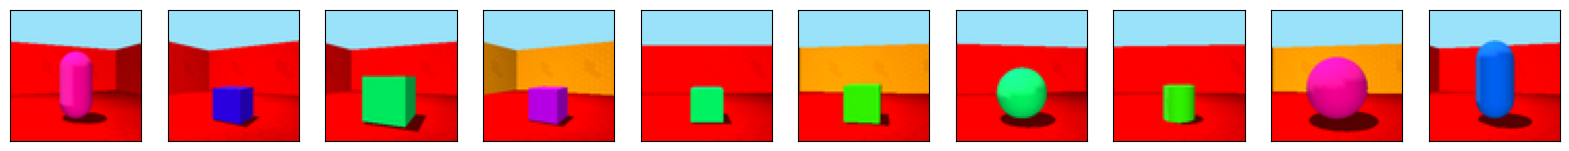

In [ ]:
tmp = train_ds.as_numpy_iterator()
imgs = tmp.next()[0]
plt.figure(figsize=(20, 4))
n=10
for i in range(n):
  img = imgs[i]
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

# Defining and training autoencoder models

some snippets are from [here](https://www.tensorflow.org/tutorials/generative/autoencoder#second_example_image_denoising)

In [ ]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## First autoencoder: very large latent space

Every original images can be described by only 6 independent ground truth parameters. In this section the model has around 600 latent parameters.

In [ ]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 64, 3)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(train_ds,
                epochs=5,
                shuffle=True,
                validation_data=val_ds)

Epoch 1/5
219/219 [==============================] - 38s 174ms/step - loss: 0.0106 - val_loss: 0.0074
Epoch 2/5
219/219 [==============================] - 46s 209ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 3/5
219/219 [==============================] - 40s 184ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/5
219/219 [==============================] - 53s 243ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/5
219/219 [==============================] - 40s 182ms/step - loss: 0.0026 - val_loss: 0.0024


In [ ]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
Total params: 1608 (6.28 KB)
Trainable params: 1608 (6.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 32, 32, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 16)        1168      
 T

as one can see, the **latent space here is very large** (first conv_2d_transpose level), with 32x32x8 = 584 parameters.

The total number of pixels in a traiinng image is 64x64x3 = 41152, i.e. only 70 times larger.  We want more compression.

In [ ]:
def compare_reconstruction(model, n=10, use_val_ds = True):
  if use_val_ds:
    tmp = val_ds.as_numpy_iterator()
  else:
    tmp = train_ds.as_numpy_iterator()


  one_batch = tmp.next()[0] #[0] means the input data (image). [1] is the same thing (it is a label y)
  batch_in = one_batch
  batch_out = model(one_batch)

  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(batch_in[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(batch_out[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

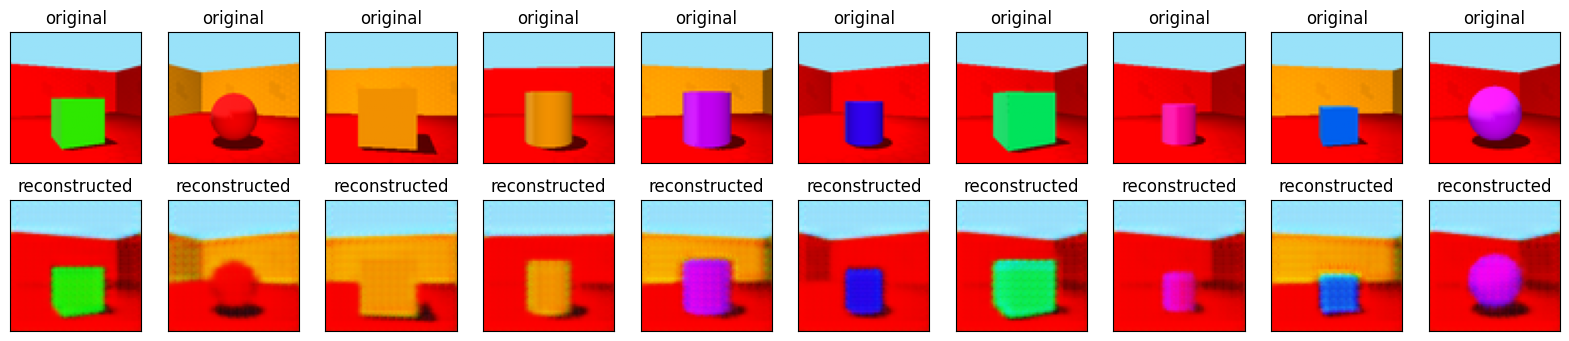

In [ ]:
compare_reconstruction(autoencoder)

Even though the compression is by a factor of $\sim$ 70, the reconstruction is a bit blurry... Definetely not optimal stuff. JPEG typically does $\sim50$ factor compression and it looks nice

## Second autoencoder: smaller latent space

In [111]:
class Autoencoder2(Model):
  def __init__(self):
    super(Autoencoder2, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 64, 3)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(3, (3, 3), activation='relu', padding='same', strides=2),
      #layers.MaxPooling2D( (2,2), padding='same'),
      #layers.Flatten(),
      #layers.Dense(256, activation='relu'),
      #layers.Dense(10, activation='relu'),
      ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(3, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')]


    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder2 = Autoencoder2()
autoencoder2.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [112]:
autoencoder2.fit(train_ds,
                epochs=5,
                shuffle=True,
                validation_data=val_ds)

Epoch 1/5
219/219 [==============================] - 41s 183ms/step - loss: 0.0916 - val_loss: 0.0523
Epoch 2/5
219/219 [==============================] - 36s 165ms/step - loss: 0.0328 - val_loss: 0.0234
Epoch 3/5
219/219 [==============================] - 39s 179ms/step - loss: 0.0193 - val_loss: 0.0168
Epoch 4/5
219/219 [==============================] - 36s 162ms/step - loss: 0.0157 - val_loss: 0.0148
Epoch 5/5
219/219 [==============================] - 38s 171ms/step - loss: 0.0137 - val_loss: 0.0126


here we made small modifications to the original autoencoder. We added (symmetrically) additional convolutional layer, and also forced the latent dimension to be of size 20 via a fully connected layer in the middle of the network.

Now there are 20 latent parameters (was 584).

In [115]:
autoencoder2.encoder.summary()
autoencoder2.decoder.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_71 (Conv2D)          (None, 16, 16, 8)         1160      
                                                                 
 conv2d_72 (Conv2D)          (None, 8, 8, 3)           219       
                                                                 
Total params: 1827 (7.14 KB)
Trainable params: 1827 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_47 (Conv2  (None, 16, 16, 3)         84        
 DTranspose)                                                    

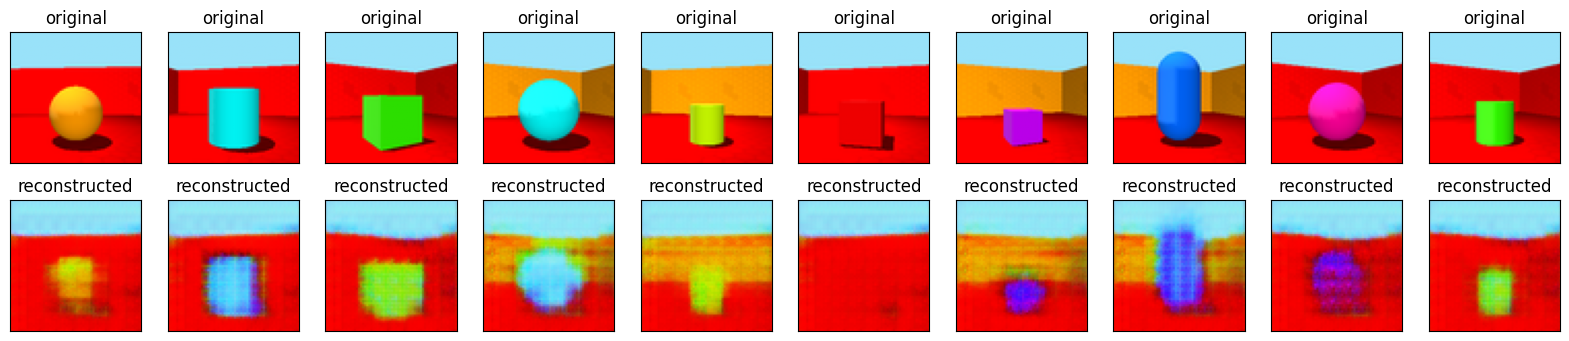

In [113]:
compare_reconstruction(autoencoder2)